In [86]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import sys
sys.path.insert(0, "C:/workspace/data-science//libs")
from simulation_core import Simulation

# Principle of work

MEV analysis was performed by next approach:

1. MEV related transactions were estimated by the algorithm which took transaction "sandwiches" with two transactions where values are identical, meaning that transactions most likely where performed to cause tokens prices changes profitable for attacker;
2. Considering that some of the transactions had relatively small capitalization (which does not exclude their possible MEV origin, due to reserves changes in each pool) there will be two sections: one with reviewing all cases and one higher capitalization transactions;
3. For additional analysis was taken information about used gas and fee conform data from Etherscan;
4. For the future analysis, due to some strange data extractions it is required to create custom subgraph collecing info about actual spent gas (found solution takes gas which sender is ready to pay).

There will be concatenation of the original swaps dataframe with gas-related info

### Setting simulation instances that contain all required info

In [87]:
# classic pools
wbtc_usdc_sim = Simulation(experiment_id = 1, x_name = 'WBTC', y_name = 'USDC', window_size = 24, 
                           base_dir = fr"{os.getcwd()}\data\real_transactions\experiment_")
weth_usdc_sim = Simulation(experiment_id = 2, x_name = 'WETH', y_name = 'USDC', window_size = 24, 
                           base_dir = fr"{os.getcwd()}\data\real_transactions\experiment_", 
                           x_index='1', y_index='0')
wbtc_dai_sim = Simulation(experiment_id = 3, x_name = 'WBTC', y_name = 'DAI', window_size = 24, 
                           base_dir = fr"{os.getcwd()}\data\real_transactions\experiment_")
fei_weth_sim = Simulation(experiment_id = 4, x_name = 'FEI', y_name = 'WETH', window_size = 24, 
                           base_dir = fr"{os.getcwd()}\data\real_transactions\experiment_")
hkmt_usdt_sim = Simulation(experiment_id = 5, x_name = 'HKMT', y_name = 'USDT', window_size = 24, 
                           base_dir = fr"{os.getcwd()}\data\real_transactions\experiment_")
ixs_weth_sim = Simulation(experiment_id = 6, x_name = 'IXS', y_name = 'WETH', window_size = 24, 
                           base_dir = fr"{os.getcwd()}\data\real_transactions\experiment_")

### Getting original swaps dataframes

In [88]:
wbtc_usdc_swaps_df = wbtc_usdc_sim.get_original_swaps_df()
weth_usdc_swaps_df = weth_usdc_sim.get_original_swaps_df()
wbtc_dai_swaps_df = wbtc_dai_sim.get_original_swaps_df()
fei_weth_swaps_df = fei_weth_sim.get_original_swaps_df()
hkmt_usdt_swaps_df = hkmt_usdt_sim.get_original_swaps_df()
ixs_weth_swaps_df = ixs_weth_sim.get_original_swaps_df()

### Setting concatenation between original swaps dataframe and gas-related info

In [89]:
classic_pools_list = [wbtc_usdc_swaps_df, weth_usdc_swaps_df, wbtc_dai_swaps_df,
                          fei_weth_swaps_df, hkmt_usdt_swaps_df, ixs_weth_swaps_df]
classic_pools_swaps_df = pd.concat(classic_pools_list)
with open('classic_pools_mevs', 'rb') as f: mevs_transactions_list = pickle.load(f)

mevs_df = pd.read_pickle('classic_pools_mevs_with_gas_df.pkl')
mevs_df['txd'] = mevs_transactions_list
mevs_df

,txd,block,block_position,gas_usage_by_tx,ether_price,tx_fee
0,0x8668f06dde23a8ccc0f2c2a594c3882e51bad15a1b7f...,11279366,54,"107,326",478.76,0.000000122000000001
1,0xbffa11c58ec26affd6c477388d70114b287c5dc13381...,11279366,62,"101,057",478.76,0.000000115500000001
2,0x668f2a34df8542f7555ace6b11097659ca0f51449766...,11792953,75,"66,799","1,721.48",0.0000002431
3,0x9e7704076894c0322297eab36eb06dda5e3cc5302549...,11792953,3,"103,505","1,721.48",0.000000301463842552
4,0x68bd6b0b089f9be253a7b47a8bf79889a6b27f68f11b...,11803970,67,"139,130","1,679.14",0.000000140400000001
...,...,...,...,...,...,...
705,0x6359588d8b7bf8851d6da7de3f092d6f88f30a54893d...,13969479,1,"87,023","3,150.83",0.000000096534076405
706,0x0da0019eabf40846f0a0fc8c7a2f53312984111754c2...,13969481,2,"88,383","3,150.83",0.000000109600853456
707,0x8d86190d1027eba21b077940f1c414e3ca06ace37839...,13969481,4,"78,261","3,150.83",0.000000117286586847
708,0x0da2303947534ae2992d7306e4856859020137e50186...,14049774,0,"88,481","2,569.59",0.000000135879365521


In [90]:
mevs_df = pd.merge(mevs_df, classic_pools_swaps_df, on='txd', how='left')

In [91]:
mevs_df['block'] = pd.to_numeric(mevs_df['block'])
mevs_df['block_position'] = pd.to_numeric(mevs_df['block_position'])
mevs_df['gas_usage_by_tx'] = pd.to_numeric(mevs_df['gas_usage_by_tx'].str.replace(',', ''))
mevs_df['ether_price'] = pd.to_numeric(mevs_df['ether_price'].str.replace(',', ''))
mevs_df['tx_fee'] = pd.to_numeric(mevs_df['tx_fee'].str.replace('wei', ''))
mevs_df['gas_price'] = pd.to_numeric(mevs_df['gas_price']) / 1000000000000000000
mevs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 710 entries, 0 to 709
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   txd              710 non-null    object        
 1   block            710 non-null    int64         
 2   block_position   710 non-null    int64         
 3   gas_usage_by_tx  710 non-null    int64         
 4   ether_price      710 non-null    float64       
 5   tx_fee           710 non-null    float64       
 6   token_in         710 non-null    object        
 7   token_out        710 non-null    object        
 8   amount_in        710 non-null    float64       
 9   amount_out       710 non-null    float64       
 10  amount_usd       710 non-null    float64       
 11  timestamp        710 non-null    datetime64[ns]
 12  sender           710 non-null    object        
 13  to               710 non-null    object        
 14  gas_price        438 non-null    float64  

### Correlation between features

Conform heatmap there are small strong connections present in the dataset. Price of ethereum correlates with block number, which is explainable by change of Ethereum price through time. In value, out value and capitalization in USD are correlated, but other features have weak correlations.

<AxesSubplot:>

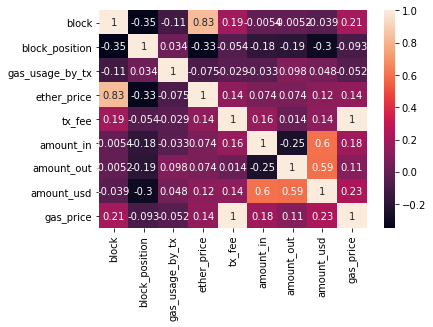

In [92]:
sns.heatmap(mevs_df[mevs_df['tx_fee'] < 0.5].corr(), annot=True)

<AxesSubplot:>

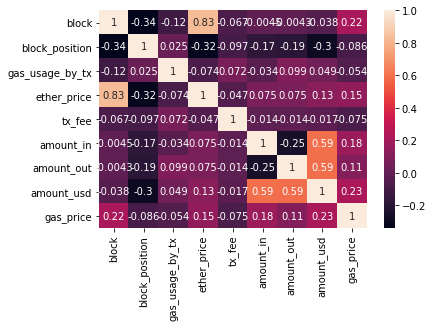

In [93]:
sns.heatmap(mevs_df.corr(), annot=True)

### Setting scatters of features

There is a problem with dataset of ```tx_fee``` values equal to 1 (possible source error) and therefore records with value around 1 were ignored.

There is almost no connection present between tx fee and gas usage. Can be seen that most of the records are concentrated around small values with some extreme outliers. Therefore it was decided to check connection with gas price.

C:\Users\Zbook\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


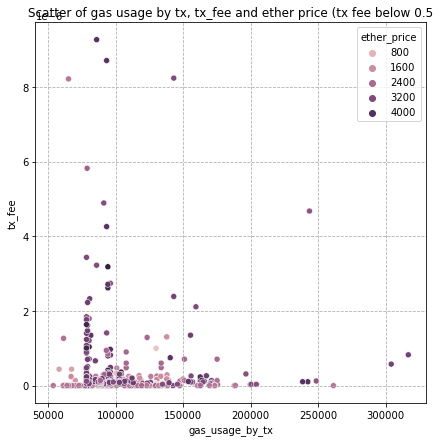

In [94]:
plt.figure(figsize=(7, 7))
sns.scatterplot(mevs_df[mevs_df['tx_fee'] < 0.5]['gas_usage_by_tx'], 
                mevs_df[mevs_df['tx_fee'] < 0.5]['tx_fee'], 
                hue=mevs_df[mevs_df['tx_fee'] < 0.5]['ether_price'])
plt.grid(True, linestyle='--')
plt.title('Scatter of gas usage by tx, tx_fee and ether price (tx fee below 0.5')
plt.show()

In [113]:
mevs_df

,txd,block,block_position,gas_usage_by_tx,ether_price,tx_fee,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,gas_price,gas_used
183,0x25cbd0282ccbf79b3ca04182e650f8e54bbf328b2b82...,10227255,265,110051,246.47,3.000000e-08,USDC,WETH,326.806092,1.363084,327.607980,2020-06-08 20:19:27,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,NaN,NaN
182,0x23a0a0c4fec8ce3bbede81ed4a86c8b1977a6faf70a6...,10227255,54,134242,246.47,3.000000e-08,WETH,USDC,1.353000,326.806092,326.322863,2020-06-08 20:19:27,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0xaaa2e80ab7d7b3c216af30fc8165e7823e74cc62,NaN,NaN
185,0xe557a7c9ac7358929c5c01025059bc585c79b1bc4ebe...,10231112,184,134242,244.00,4.000000e-08,WETH,USDC,3.000000,727.983165,725.226810,2020-06-09 10:59:47,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0xaaa2e80ab7d7b3c216af30fc8165e7823e74cc62,NaN,NaN
184,0x0472b0bda03549ad0ced339ad1872b76fd9a2ee1f6df...,10231112,207,110039,244.00,4.000000e-08,USDC,WETH,727.983165,3.007581,727.494505,2020-06-09 10:59:47,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,NaN,NaN
186,0x5e4e8e817bc0b69936ac65c07e45547438788f4a1fac...,10245640,118,134242,230.21,5.720000e-08,WETH,USDC,3.000000,685.052827,687.037932,2020-06-11 17:08:03,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0xaaa2e80ab7d7b3c216af30fc8165e7823e74cc62,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,0x0da2303947534ae2992d7306e4856859020137e50186...,14049774,0,88481,2569.59,1.358794e-07,WETH,IXS,9.850424,153715.045388,27919.796295,2022-01-21 15:38:15,0x0000000000d41c96294ccdac8612bdfe29c641af,0x0000000000d41c96294ccdac8612bdfe29c641af,1.358794e-07,108545
181,0xa140f3f688511238df8a9e564a97e480e0cec7868bfe...,14054109,1,104051,2412.23,3.064305e-07,WBTC,USDC,1.276562,37711.479807,37647.553852,2022-01-22 07:36:40,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,3.064305e-07,2000000
180,0x94fff3ef66ab898bb1afbb9128da1ce611cc45a592ab...,14054109,3,94113,2412.23,8.446549e-07,USDC,WBTC,37711.479807,1.286411,37647.553852,2022-01-22 07:36:40,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,8.446549e-07,164705
568,0x6eb7c947848fa63ebfe5ffa539a166afdb4d8043600a...,14079833,0,102974,2464.13,8.656122e-08,USDT,HKMT,122981.406976,983689.039976,122823.392267,2022-01-26 07:12:08,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,0x00000000008c4fb1c916e0c88fd4cc402d935e7d,8.656122e-08,2000000


Most of the records are placed in the lowest left section, meaning that most of transactions are keeping a small level of gas consumption, but the most interesting moment is that all those low-value cases conform hue are having smallest ```gas_price``` values, meaning that most of the attacks are performed during low gas price. Therefore, low gas price will not cause higher transaction values (there is no strong correlation) but causes bigger MEV activity.

C:\Users\Zbook\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


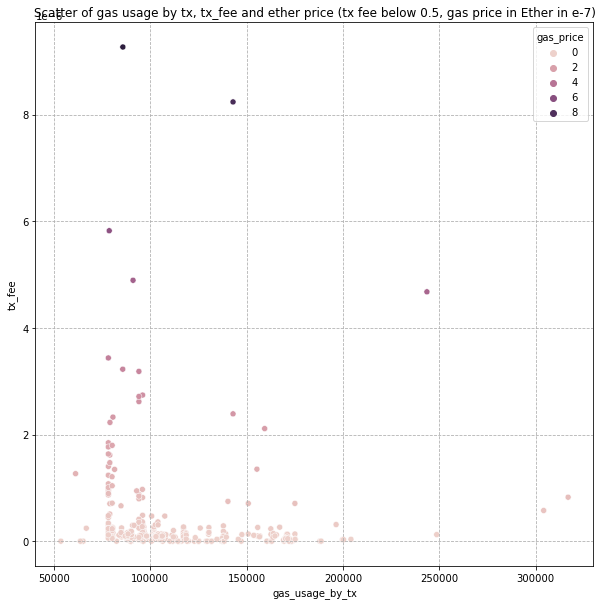

In [114]:
plt.figure(figsize=(10, 10))
sns.scatterplot(mevs_df[mevs_df['tx_fee'] < 0.5]['gas_usage_by_tx'], 
                mevs_df[mevs_df['tx_fee'] < 0.5]['tx_fee'], 
                hue=mevs_df[mevs_df['tx_fee'] < 0.5]['gas_price'])
plt.grid(True, linestyle='--')
plt.title('Scatter of gas usage by tx, tx_fee and ether price (tx fee below 0.5, gas price in Ether in e-7)')
plt.show()

Out of 710 MEV attacks there are 36 cases of strange values, where ```tx_fee``` is set to 1, meaning that those are outliers caused by some inner data extraction error.

In [117]:
print(len(mevs_df))

710


In [118]:
print(len(mevs_df[mevs_df['tx_fee'] > 0.5]))

36


C:\Users\Zbook\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


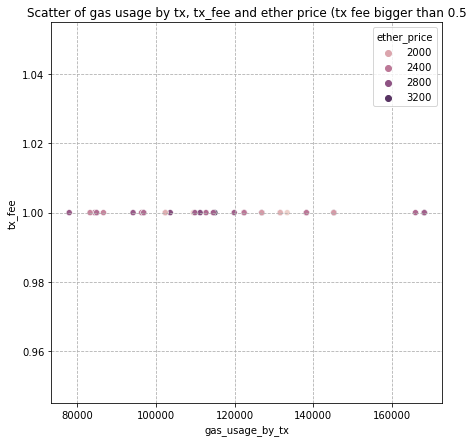

In [97]:
plt.figure(figsize=(7, 7))
sns.scatterplot(mevs_df[mevs_df['tx_fee'] > 0.5]['gas_usage_by_tx'], 
                mevs_df[mevs_df['tx_fee'] > 0.5]['tx_fee'], 
                hue=mevs_df[mevs_df['tx_fee'] > 0.5]['ether_price'])
plt.grid(True, linestyle='--')
plt.title('Scatter of gas usage by tx, tx_fee and ether price (tx fee bigger than 0.5')
plt.show()

There is no observable connection between ether price and fee or capitalization, but can be seen that most of the records are concentrated around smaller fee values

C:\Users\Zbook\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


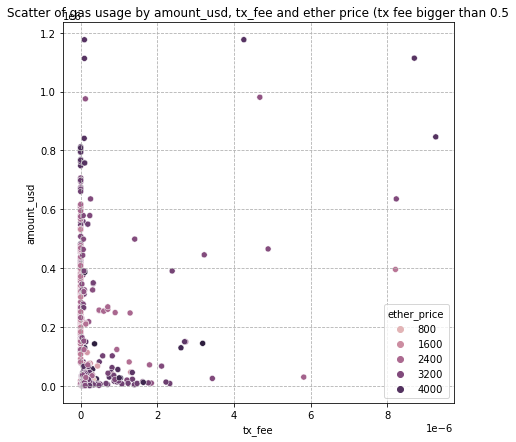

In [98]:
plt.figure(figsize=(7, 7))
sns.scatterplot(mevs_df[mevs_df['tx_fee'] < 0.5]['tx_fee'], 
                mevs_df[mevs_df['tx_fee'] < 0.5]['amount_usd'], 
                hue=mevs_df[mevs_df['tx_fee'] < 0.5]['ether_price'])
plt.grid(True, linestyle='--')
plt.title('Scatter of gas usage by amount_usd, tx_fee and ether price (tx fee bigger than 0.5')
plt.show()

Once more, all records are more concentrated on lower values of the gas price, meaning that lower gas price stimulates MEV attacks

C:\Users\Zbook\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


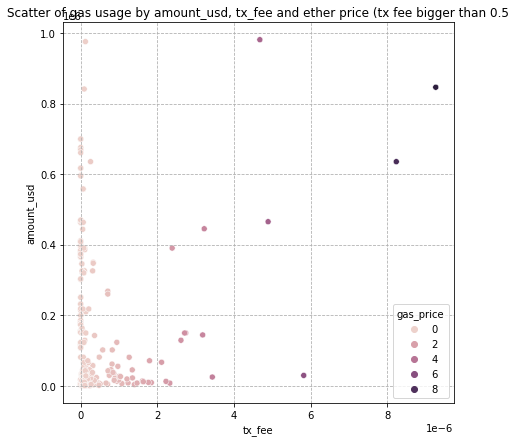

In [119]:
plt.figure(figsize=(7, 7))
sns.scatterplot(mevs_df[mevs_df['tx_fee'] < 0.5]['tx_fee'], 
                mevs_df[mevs_df['tx_fee'] < 0.5]['amount_usd'], 
                hue=mevs_df[mevs_df['tx_fee'] < 0.5]['gas_price'])
plt.grid(True, linestyle='--')
plt.title('Scatter of gas usage by amount_usd, tx_fee and ether price (tx fee bigger than 0.5')
plt.show()

There are only some unique attackers that are ready to pay higher transaction fees. Those unique cases are going out of the distribution for most of the records and can be seen that some addresses are representing a big number of records. It means that most of the records belong to several addresses. To ensure that, further countplot will be done

C:\Users\Zbook\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


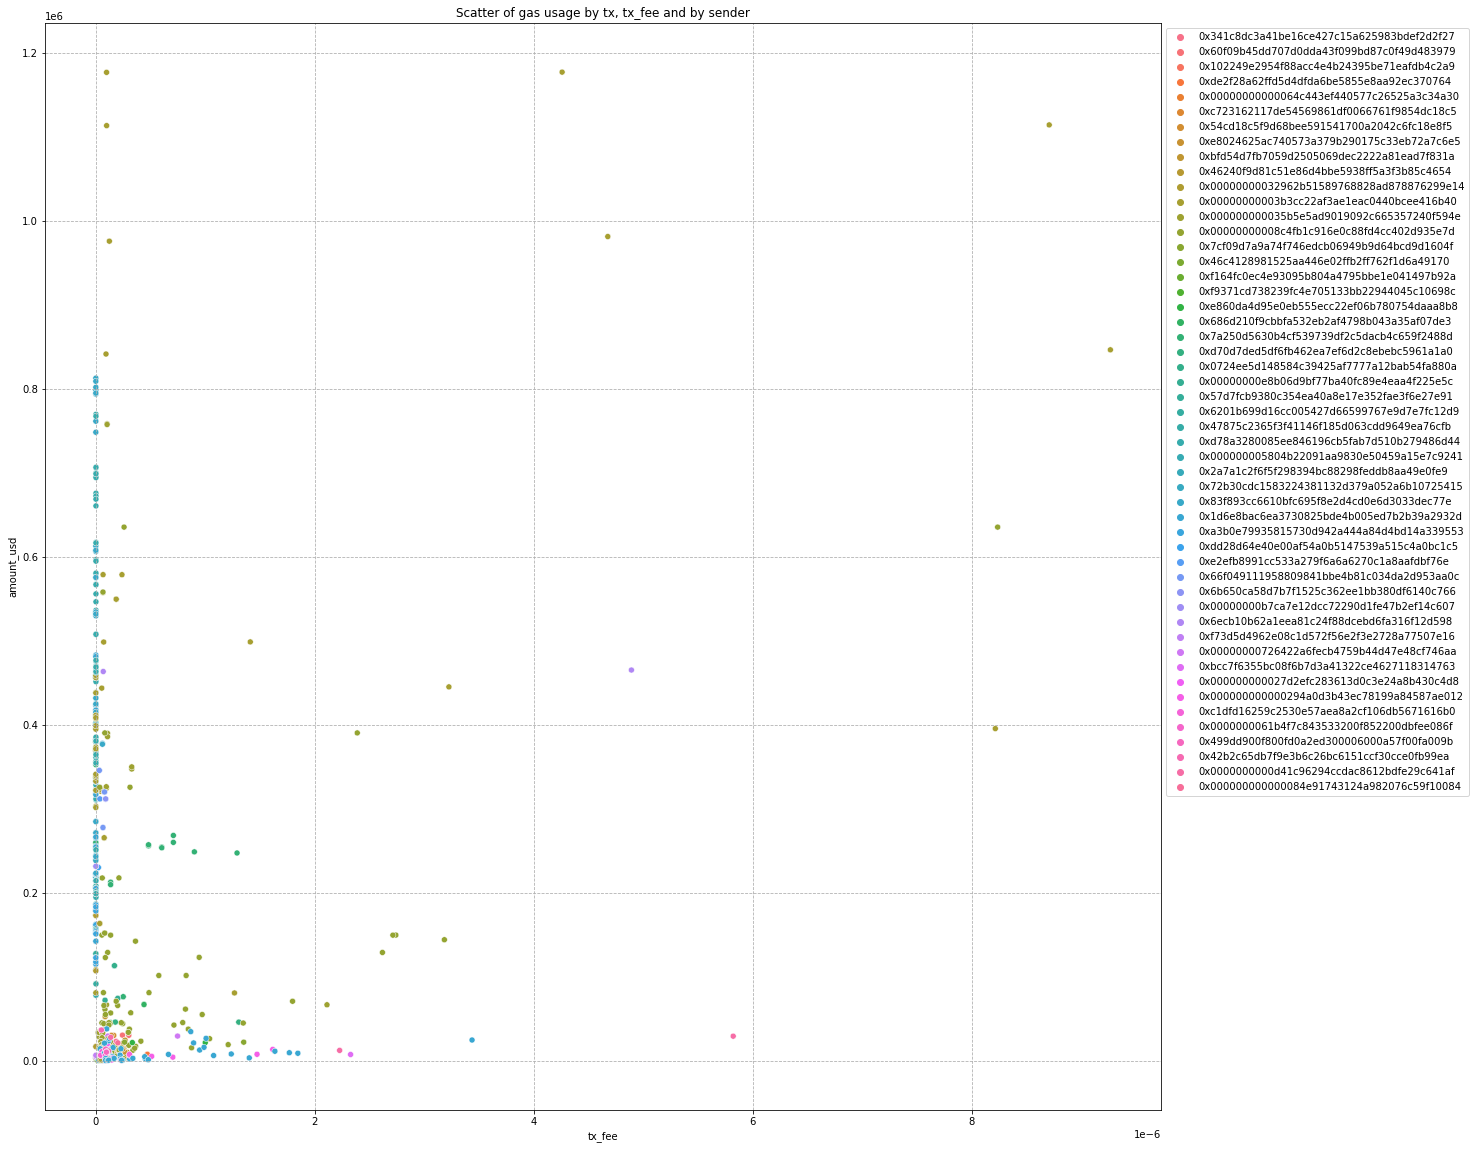

In [99]:
plt.figure(figsize=(20, 20))
sns.scatterplot(mevs_df[mevs_df['tx_fee'] < 0.5]['tx_fee'], 
                mevs_df[mevs_df['tx_fee'] < 0.5]['amount_usd'], 
                hue=mevs_df[mevs_df['tx_fee'] < 0.5]['sender'])
plt.grid(True, linestyle='--')
plt.title('Scatter of gas usage by tx, tx_fee and by sender')
plt.legend(loc=2, bbox_to_anchor=(1,1))
plt.show()

Only in unique cases attackers are willing to perform transaction with high gas usage and high transaction fees, demonstrating desire for most of the attackers to minimize their losses

C:\Users\Zbook\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


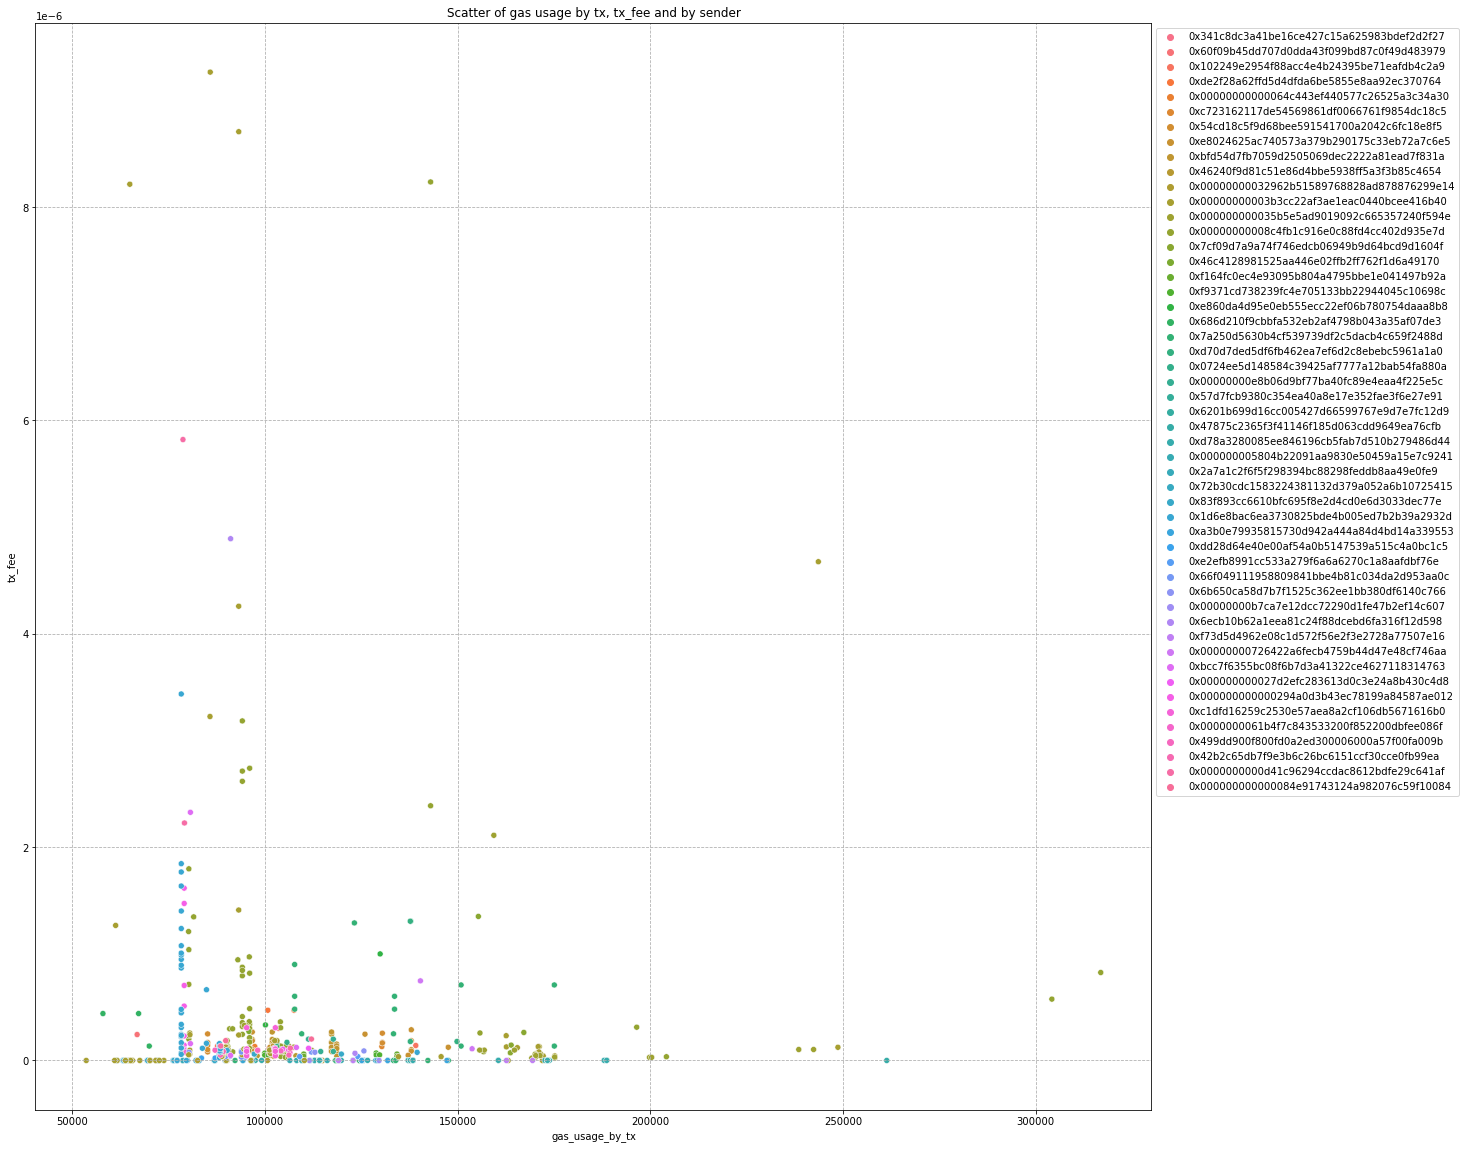

In [100]:
plt.figure(figsize=(20, 20))
sns.scatterplot(mevs_df[mevs_df['tx_fee'] < 0.5]['gas_usage_by_tx'], 
                mevs_df[mevs_df['tx_fee'] < 0.5]['tx_fee'], 
                hue=mevs_df[mevs_df['tx_fee'] < 0.5]['sender'])
plt.grid(True, linestyle='--')
plt.title('Scatter of gas usage by tx, tx_fee and by sender')
plt.legend(loc=2, bbox_to_anchor=(1,1))
plt.show()

<AxesSubplot:>

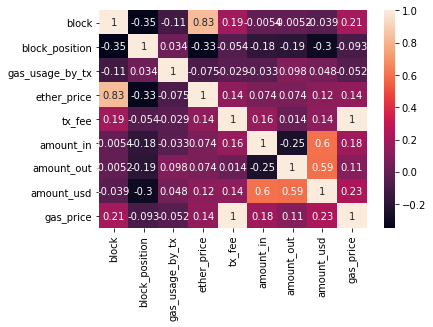

In [101]:
sns.heatmap(mevs_df[mevs_df['tx_fee'] < 1].corr(), annot=True)

In [102]:
mevs_df.sort_values(by=['block'], inplace=True)

In [103]:
mevs_df[mevs_df['tx_fee'] == 1]

,txd,block,block_position,gas_usage_by_tx,ether_price,tx_fee,token_in,token_out,amount_in,amount_out,amount_usd,timestamp,sender,to,gas_price,gas_used
226,0x46336e4f9194fa7d412f60c56783c4201c864263648b...,11917692,3,109510,1625.17,1.0,USDC,WETH,83360.918419,51.176754,83633.605938,2021-02-24 04:21:00,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,NaN,NaN
227,0xa2baff0fe50d666e5436647a1a944a487571f02fc448...,11917692,0,133340,1625.17,1.0,WETH,USDC,51.023902,83360.918419,83446.288967,2021-02-24 04:21:00,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x7d92ad7e1b6ae22c6a43283af3856028cd3d856a,NaN,NaN
298,0x0572bad13864e29ab7478362118dd1461fbfd5451f95...,12284230,0,138226,2357.59,1.0,WETH,USDC,71.274500,175035.085064,174194.341099,2021-04-21 14:57:02,0x9e244643b91ecc1498718cb4f5d22d14a9b121a1,0x9e244643b91ecc1498718cb4f5d22d14a9b121a1,NaN,NaN
299,0x7f6607c77fb30dce3a1971ce0462dd2b18b55b1170cc...,12284230,2,122414,2357.59,1.0,USDC,WETH,175035.085064,71.570157,174620.836477,2021-04-21 14:57:02,0x9e244643b91ecc1498718cb4f5d22d14a9b121a1,0x9e244643b91ecc1498718cb4f5d22d14a9b121a1,NaN,NaN
303,0xe8121e1611eb0e3c007be5221ad5377c5d24036bf8ea...,12292199,2,122414,2410.48,1.0,USDC,WETH,194123.366917,79.469496,194618.619689,2021-04-22 20:35:32,0x9e244643b91ecc1498718cb4f5d22d14a9b121a1,0x9e244643b91ecc1498718cb4f5d22d14a9b121a1,NaN,NaN
302,0x147fd639305457d7af2f3b1a5fb41a5e9e65f978950d...,12292199,0,138238,2410.48,1.0,WETH,USDC,79.292600,194123.366917,194350.198984,2021-04-22 20:35:32,0x9e244643b91ecc1498718cb4f5d22d14a9b121a1,0x9e244643b91ecc1498718cb4f5d22d14a9b121a1,NaN,NaN
304,0x7a34472d0bee1d4deeaf22a46e9f5241a190d02e029e...,12292710,0,138238,2410.48,1.0,WETH,USDC,81.468700,196790.279501,197217.029681,2021-04-22 22:27:24,0x9e244643b91ecc1498718cb4f5d22d14a9b121a1,0x9e244643b91ecc1498718cb4f5d22d14a9b121a1,NaN,NaN
305,0xf61660433cfca7f9a7dd6a547e8257769c1846b35a4e...,12292710,2,122414,2410.48,1.0,USDC,WETH,196790.279501,82.029677,197988.741335,2021-04-22 22:27:24,0x9e244643b91ecc1498718cb4f5d22d14a9b121a1,0x9e244643b91ecc1498718cb4f5d22d14a9b121a1,NaN,NaN
66,0x8bba445d4bc19f5aa8eec48f5748db2cfca99bdbb80d...,12317226,2,112734,2534.90,1.0,WBTC,USDC,0.972238,53572.033252,53491.929008,2021-04-26 17:10:32,0xd59e5b41482ee6283c22e1a6a20756da512ffa97,0xd59e5b41482ee6283c22e1a6a20756da512ffa97,1.000000e-18,300000
67,0xaddf9f0aa298bf9b2a3aa6dde88dba8b3b7eea43c5aa...,12317226,0,165920,2534.90,1.0,USDC,WBTC,52333.917800,0.972238,52255.664864,2021-04-26 17:10:32,0xd59e5b41482ee6283c22e1a6a20756da512ffa97,0xd59e5b41482ee6283c22e1a6a20756da512ffa97,1.000000e-18,400000


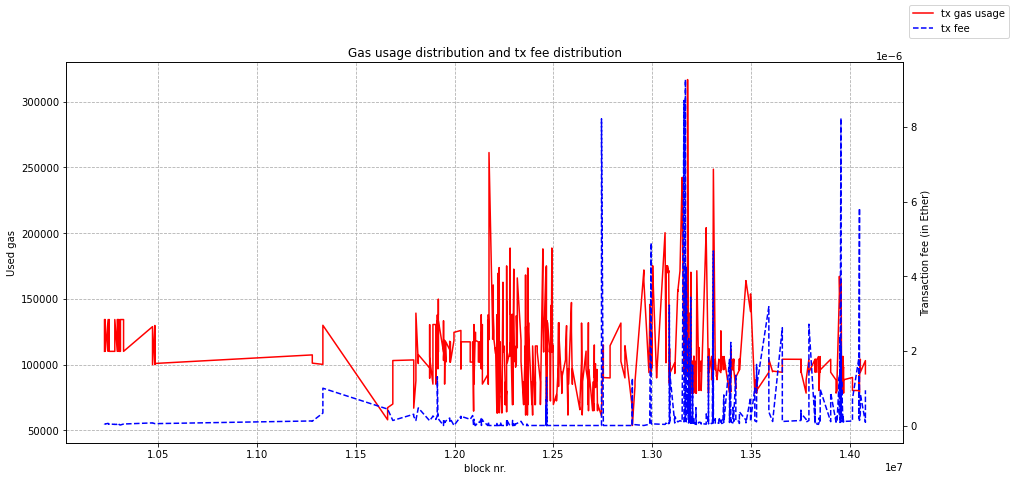

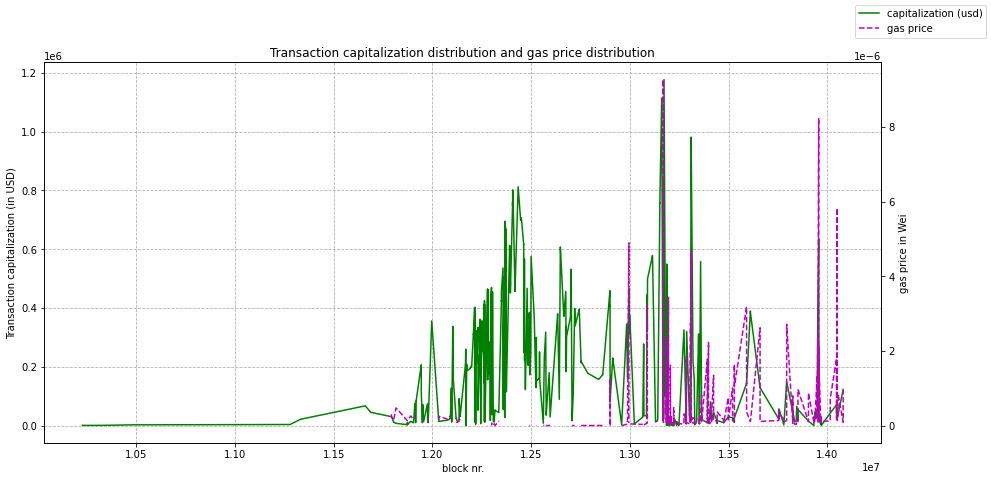

In [104]:
# gas usage and tx fee
fig, ax = plt.subplots(figsize=(15, 7))
ax2 = ax.twinx()

ax.plot(mevs_df['block'], mevs_df['gas_usage_by_tx'], color='r', label='tx gas usage')
ax2.plot(mevs_df[mevs_df['tx_fee'] != 1]['block'], mevs_df[mevs_df['tx_fee'] != 1]['tx_fee'], color='b', linestyle='--', label='tx fee')
ax.set_title('Gas usage distribution and tx fee distribution')
ax.set_xlabel('block nr.')
ax.set_ylabel('Used gas')
ax2.set_ylabel('Transaction fee (in Ether)')

ax.grid(True, linestyle='--')
fig.legend()
plt.show()


# capitalization and gas price
fig, ax = plt.subplots(figsize=(15, 7))
ax2 = ax.twinx()

ax.plot(mevs_df['block'], mevs_df['amount_usd'], color='g', label='capitalization (usd)')
ax2.plot(mevs_df['block'], mevs_df['gas_price'], color='m', linestyle='--', label='gas price')
ax.set_title('Transaction capitalization distribution and gas price distribution')
ax.set_xlabel('block nr.')
ax.set_ylabel('Transaction capitalization (in USD)')
ax2.set_ylabel('gas price in Wei')

ax.grid(True, linestyle='--')
fig.legend()
plt.show()

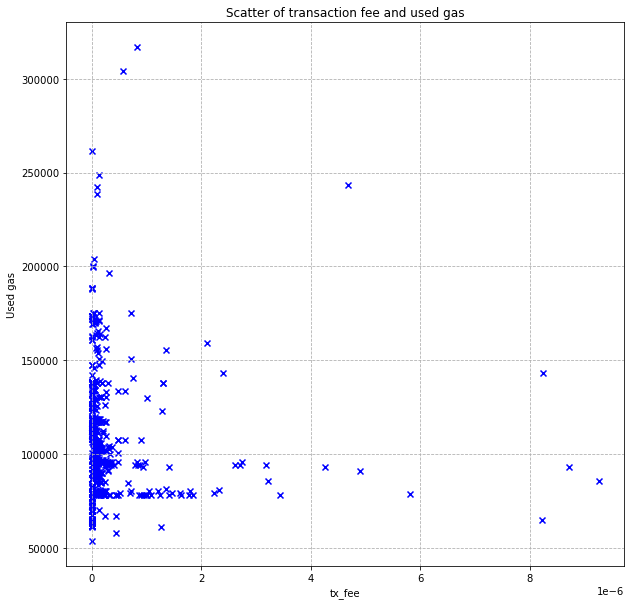

In [105]:
# gas usage plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(mevs_df[mevs_df['tx_fee'] != 1]['tx_fee'], 
           mevs_df[mevs_df['tx_fee'] != 1]['gas_usage_by_tx'], 
           marker='x', color='b')
ax.set_title('Scatter of transaction fee and used gas')
ax.set_xlabel('tx_fee')
ax.set_ylabel('Used gas')
ax.grid(True, linestyle='--')
plt.show()


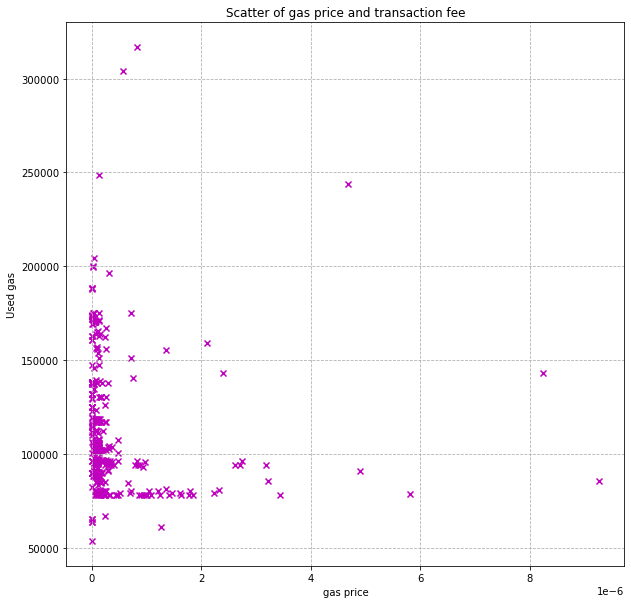

In [106]:
# gas usage plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(mevs_df[mevs_df['tx_fee'] != 1]['gas_price'], 
           mevs_df[mevs_df['tx_fee'] != 1]['gas_usage_by_tx'], 
           marker='x', color='m')
ax.set_title('Scatter of gas price and transaction fee')
ax.set_xlabel('gas price')
ax.set_ylabel('Used gas')
ax.grid(True, linestyle='--')
plt.show()


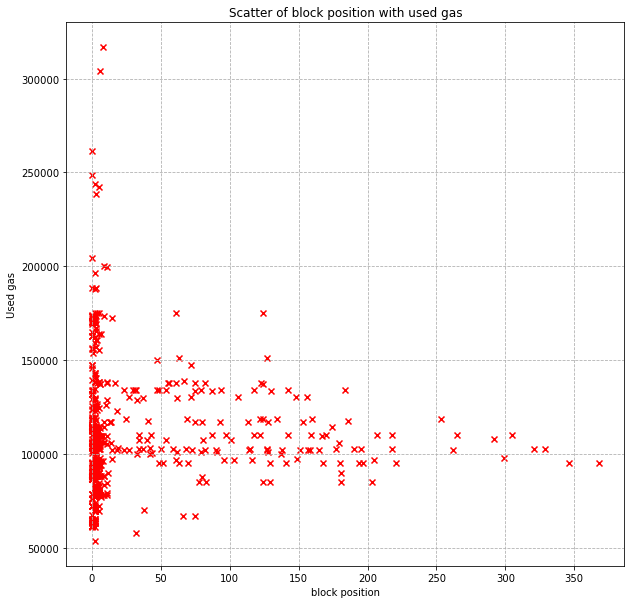

In [107]:
# gas usage plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(mevs_df[mevs_df['tx_fee'] != 1]['block_position'], 
           mevs_df[mevs_df['tx_fee'] != 1]['gas_usage_by_tx'], 
           marker='x', color='r')
ax.set_title('Scatter of block position with used gas')
ax.set_xlabel('block position')
ax.set_ylabel('Used gas')
ax.grid(True, linestyle='--')
plt.show()


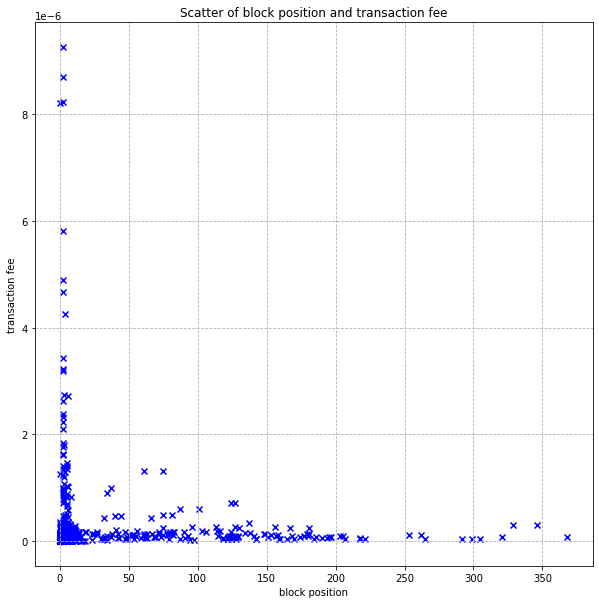

In [108]:
# gas usage plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(mevs_df[mevs_df['tx_fee'] != 1]['block_position'], 
           mevs_df[mevs_df['tx_fee'] != 1]['tx_fee'], 
           marker='x', color='b')
ax.set_title('Scatter of block position and transaction fee')
ax.set_xlabel('block position')
ax.set_ylabel('transaction fee')
ax.grid(True, linestyle='--')
plt.show()


In most of the cases, MEV transactions are the first and the third ones (which corresponds to the basic attack pattern), but there are some specific cases of attacks happening little later (till position 9). All values above 10-th position are more likely to be outliers.

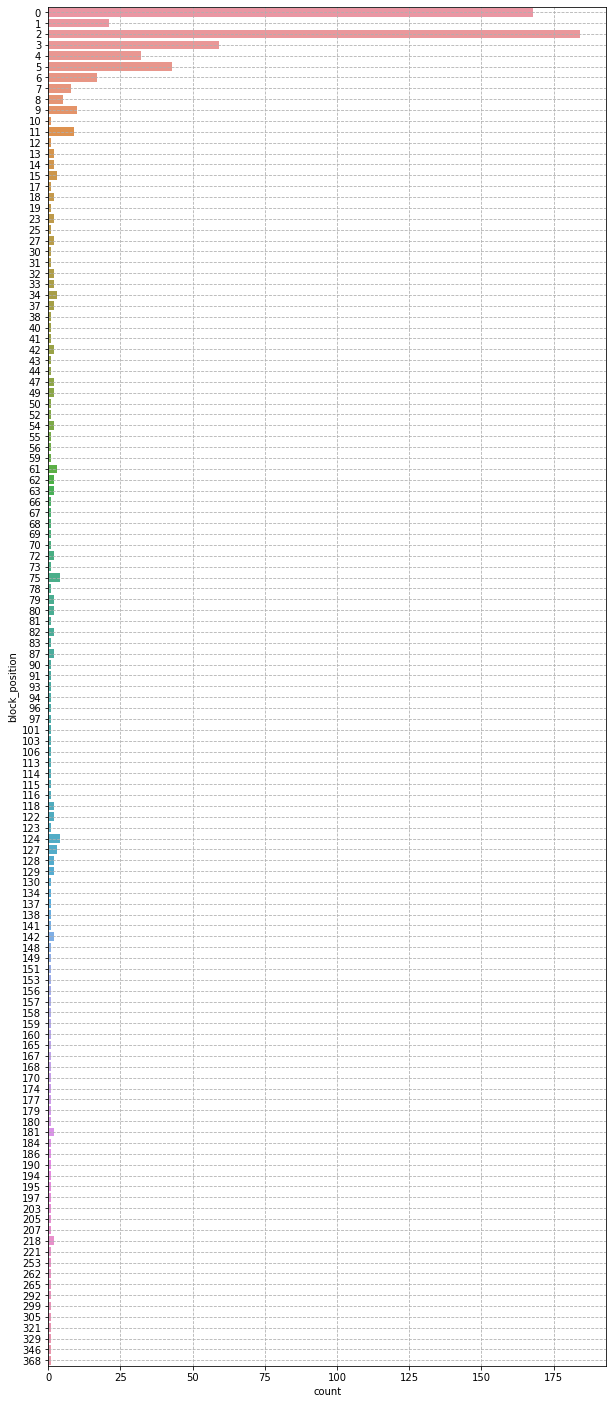

In [109]:
plt.figure(figsize=(10, 25))
sns.countplot(y='block_position', data=mevs_df)
plt.grid(True, linestyle='--')
plt.show()

Even MEV attacks with position in block further than 9-th position are looking like MEV attacks conform their max value, median and mean

In [127]:
print(fr'max capitalization registered after 9-th position in the block = {mevs_df[mevs_df["block_position"] > 9]["amount_usd"].max()}')
print(fr'min capitalization registered after 9-th position in the block = {mevs_df[mevs_df["block_position"] > 9]["amount_usd"].min()}')
print(fr'mean capitalization registered after 9-th position in the block = {mevs_df[mevs_df["block_position"] > 9]["amount_usd"].mean()}')
print(fr'median capitalization registered after 9-th position in the block = {mevs_df[mevs_df["block_position"] > 9]["amount_usd"].median()}')


max capitalization registered after 9-th position in the block = 675492.5869615654
min capitalization registered after 9-th position in the block = 326.3228627111209
mean capitalization registered after 9-th position in the block = 43035.864929631505
median capitalization registered after 9-th position in the block = 11693.344351874877


There are several addresses with around 40 MEV attacks performed on the classic tokens pools. On the chart below are presented count of MEV-transactions for all addresses and current chart demonstrates how important it will be to check MEV attack performance over all pools for all addresses, making a blacklist of addresses, their profits and amount of performed attacks

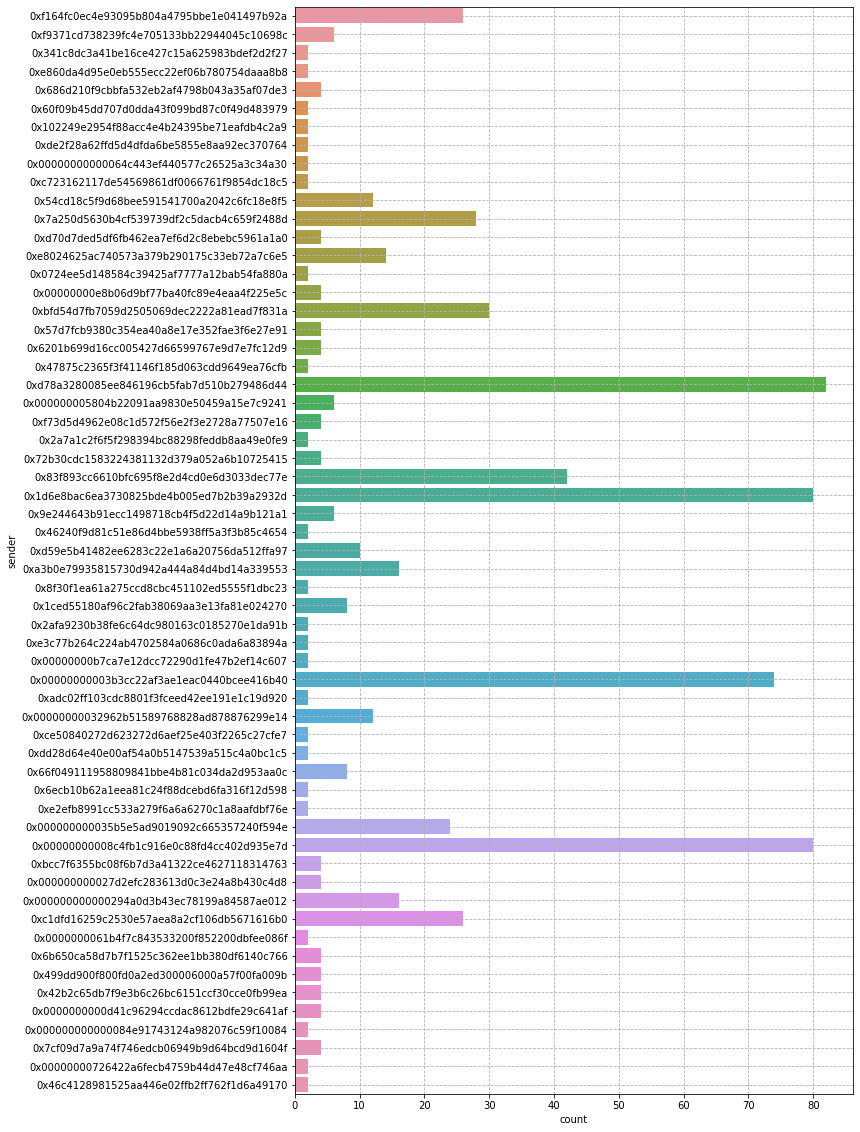

In [110]:
fig = plt.figure(figsize=(10, 20))
sns.countplot(y='sender', data=mevs_df)
plt.grid(True, linestyle='--')
plt.show()